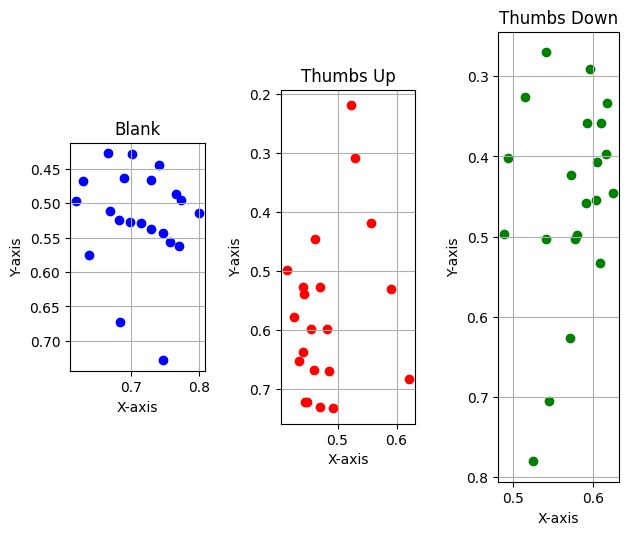

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import random

def plotData(df, row_index, ax, color, title):
    if df is not None:
        row = df.iloc[row_index]
        x_coords = [row[f"landmark_{i}_x"] for i in range(0, num_landmarks)]
        y_coords = [row[f"landmark_{i}_y"] for i in range(0, num_landmarks)]
        ax.scatter(x_coords, y_coords, color=color)
        ax.set_title(title)
        ax.set_xlabel("X-axis")
        ax.set_ylabel("Y-axis")
        ax.invert_yaxis()
        ax.grid(True)
        ax.set_aspect('equal')

#row_index = 0  # Random row
numPlots = 0
num_landmarks = 21 # Number of landmarks/features

try:
    df_blank = pd.read_csv("blank_data.csv")
    numPlots += 1
except:
    print("blank_data.csv not found. Please run the script to generate the data first.")
    df_blank = None

try:
    df_up = pd.read_csv("thumbs_up_data.csv")
    numPlots += 1

except:
    print("thumbs_up_data.csv not found. Please run the script to generate the data first.")
    df_up = None

try:
    df_down = pd.read_csv("thumbs_down_data.csv")
    numPlots += 1
except:
    print("thumbs_down_data.csv not found. Please run the script to generate the data first.")
    df_down = None


fig, axes = plt.subplots(1, numPlots)

if numPlots == 1:
    axes = [axes]

# Pick random entry to plot
plotData(df_blank, random.randint(0, len(df_blank) - 1), axes[0], 'blue', df_blank['gesture_label'][0])
plotData(df_up, random.randint(0, len(df_down) - 1), axes[1], 'red', df_up['gesture_label'][0])
plotData(df_down, random.randint(0, len(df_down) - 1), axes[2], 'green', df_down['gesture_label'][0])

# Check to see data points make sense, i.e., plots looks like a hand
plt.subplots_adjust(wspace=5)
plt.tight_layout()
plt.show()

In [14]:
num_output_classes = 3

batch_size = 128
step_to_print = 100
num_epochs = 500
num_neurons_layer_1 = 128
num_neurons_layer_2 = 64

In [15]:
# Initialize weights and biases

import tensorflow as tf

random_normal = tf.initializers.RandomNormal()

weights = {
    'w_l1': tf.Variable(random_normal([num_landmarks, num_neurons_layer_1])),
    'w_l2': tf.Variable(random_normal([num_neurons_layer_1, num_neurons_layer_2])),
    'w_out': tf.Variable(random_normal([num_neurons_layer_2, num_output_classes]))
}
biases = {
    'b_l1': tf.Variable(tf.zeros([num_neurons_layer_1])),
    'b_l2': tf.Variable(tf.zeros([num_neurons_layer_2])),
    'b_out': tf.Variable(tf.zeros([num_output_classes]))
}

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Combine the datasets for training
df = pd.concat([df_blank, df_up, df_down])

df_size = len(df)

X = df.drop(columns=["gesture_label"]) # get the landmark coordinates
y = df["gesture_label"].values # get the gesture labels

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)  # Encodes labels as integers (0, 1, 2)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1) # batch & shuffle the data

# # Build the neural network model
# model = Sequential([
#     Dense(128, activation='relu', input_shape=(63,)),  # Hidden layer 1
#     Dropout(0.3),  # Dropout for regularization
#     Dense(64, activation='relu'),  # Hidden layer 2
#     Dropout(0.3),
#     Dense(3, activation='softmax')  # Output layer (3 classes)
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
# history = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_test, y_test))

# # Evaluate the model
# loss, accuracy = model.evaluate(x_test, y_test)
# print(f"Test Accuracy: {accuracy:.2f}")
# print(f"Loss: {loss:.2f}")

In [17]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class FCNN(Model):
    def __init__(self, num_neurons_layer_1, num_neurons_layer_2, num_output_classes, **kwargs):
        super(FCNN, self).__init__(**kwargs)
        self.num_neurons_layer_1 = num_neurons_layer_1
        self.num_neurons_layer_2 = num_neurons_layer_2
        self.num_output_classes = num_output_classes
        self.l1 = Dense(num_neurons_layer_1, activation='relu')
        self.l2 = Dense(num_neurons_layer_2, activation='relu')
        self.out = Dense(num_output_classes)

    def call(self, x, training=False):
        x = self.l1(x)
        x = self.l2(x)
        x = self.out(x)
        if not training:
            x = tf.nn.softmax(x)
        return x

    def get_config(self):
        config = super(FCNN, self).get_config()
        config.update({
            "num_neurons_layer_1": self.num_neurons_layer_1,
            "num_neurons_layer_2": self.num_neurons_layer_2,
            "num_output_classes": self.num_output_classes,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [18]:
# Loss function
def loss_func(x,y):
    y = tf.cast(y, tf.int64)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    return tf.reduce_mean(loss)

In [19]:
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

In [20]:
fcnn = FCNN(num_neurons_layer_1, num_neurons_layer_2, num_output_classes) #  Instance of the model

optimizer = tf.optimizers.SGD() # Optimizer - Stochastic Gradient Descent

In [21]:
def optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        pred = fcnn(x, training=True)
        loss = loss_func(pred, y)
        
    weights_and_biases = fcnn.trainable_variables

    # Compute gradients.
    gradients = g.gradient(loss, weights_and_biases)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, weights_and_biases))

In [22]:
# Train the model
training_steps = (df_size // batch_size) * num_epochs

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    optimization(batch_x, batch_y)
    
    if step % step_to_print == 0:
        pred = fcnn(batch_x, training=True)
        loss = loss_func(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 100, loss: 0.846250, accuracy: 0.562500
step: 200, loss: 0.712461, accuracy: 0.625000
step: 300, loss: 0.595569, accuracy: 0.726562
step: 400, loss: 0.540253, accuracy: 0.789062
step: 500, loss: 0.438627, accuracy: 0.882812
step: 600, loss: 0.402193, accuracy: 0.890625
step: 700, loss: 0.353665, accuracy: 0.914062
step: 800, loss: 0.328374, accuracy: 0.875000
step: 900, loss: 0.282416, accuracy: 0.898438
step: 1000, loss: 0.285783, accuracy: 0.867188
step: 1100, loss: 0.268456, accuracy: 0.898438
step: 1200, loss: 0.235805, accuracy: 0.906250
step: 1300, loss: 0.182358, accuracy: 0.937500
step: 1400, loss: 0.218646, accuracy: 0.914062
step: 1500, loss: 0.215636, accuracy: 0.906250
step: 1600, loss: 0.175880, accuracy: 0.937500
step: 1700, loss: 0.161852, accuracy: 0.945312
step: 1800, loss: 0.152328, accuracy: 0.968750
step: 1900, loss: 0.148596, accuracy: 0.960938
step: 2000, loss: 0.118993, accuracy: 0.960938
step: 2100, loss: 0.147624, accuracy: 0.937500
step: 2200, loss: 0.14

In [23]:
# Test the model
pred = fcnn(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.993520


In [24]:
# model.save("hand_gesture_model.keras") # Save the model
fcnn.save("hand_gesture_model.keras") # Save the model